In [1]:
import os
import platform 
import gc

import re
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = None


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb

import warnings 
warnings.filterwarnings('ignore')

/Users/betashort/opt/anaconda3/envs/default/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
print(platform.system())
if platform.system() == 'Darwin':
    path = "/Users/betashort/Google Drive/Prediction_Salary/"
elif platform.system() == 'Windows':
    path = "C://Users/ail11208/Google ドライブ/SIGNATE_mynavi2019/"

Darwin


# input

In [3]:
X = pd.read_csv('input/train_data.csv')
X_test = pd.read_csv('input/test_data.csv')
test_id = X_test['id']

In [4]:
y = X['salary']
X = X.drop(['salary', 'id'], axis=1)
X_test = X_test.drop(['id'], axis=1)

# preprocessing

## 66歳以上を削除

In [5]:
drop_rows = X[X['age'] >= 66].index.tolist()
X = X.drop(drop_rows)
y = y.drop(drop_rows)

# Feature Engineering

In [6]:
def create_feature(df):
    #position-age
    df['MA'] = df['age'].apply(lambda x: 1 if (x >= 26) else 0)
    df['GM'] =  df['age'].apply(lambda x: 1 if (x >= 31) else 0)
    df['not_noname'] = df['age'].apply(lambda x: 1 if (x <= 31) else 0)
    
    df['position_age'] = 0
    df['position_age'][(df['age'] >=18) & (df['age'] <=25)] = 0
    df['position_age'][(df['age'] >=26) & (df['age'] <=31)] = 1
    df['position_age'][(df['age'] >=32) & (df['age'] <=36)] = 2
    df['position_age'][(df['age'] >=37)& (df['age'] <=58)] = 3
    df['position_age'][(df['age'] >=59)] = 4
    return df

In [7]:
X = create_feature(X)
X_test = create_feature(X_test)

# Labeling

In [8]:
def labeling(X, X_test, y):
    col_category = []
    for i in X.columns:
        if X[i].dtype == 'object':
            
            # ======== ラベルエンコーディング ==========
            le = LabelEncoder()
            X[f'{i}_label'] = le.fit_transform(X[i])
            X_test[f'{i}_label'] = le.transform(X_test[i])
            
            col_category.append(f'{i}_label')
            
            
            # ========= ランキング ==============
            maps = pd.concat([X, np.exp(y)], axis=1).groupby(i)['salary'].mean().sort_values(ascending=False).index
            maps = pd.DataFrame({i: maps, 'rank': np.linspace(0, maps.shape[0]-1, maps.shape[0])})
            maps = dict(maps.to_dict(orient='split')['data'])
            X[f'{i}_rank'] = X[i].map(maps)
            X_test[f'{i}_rank'] = X_test[i].map(maps)
            
            col_category.append(f'{i}_rank')
            
            '''
            # ===== targeting =======
            data_tmp = pd.DataFrame({i:X[i], 'target':y})
            target_mean = data_tmp.groupby(i)['target'].mean()
            
            X_test[f'{i}_target'] = X_test[i].map(target_mean)
            #X_test[f'{c}_target_log'] = np.log(X_test[c].map(target_mean))
            
            tmp = np.repeat(np.nan, X.shape[0])
            
            kf = KFold(n_splits=4, shuffle=True, random_state=72)
            
            for idx_1, idx_2 in kf.split(X):
                target_mean = data_tmp.iloc[idx_1].groupby(i)['target'].mean()
                tmp[idx_2] = X[i].iloc[idx_2].map(target_mean)
                X[f'{i}_target'] = tmp
                #X[f'{c}_target_log'] = np.log(tmp)
            
            col_category.append(f'{i}_target')
            #new_col_category.append(f'{c}_target_log')
            '''
            # ===== 元のラベルの削除 =====
            X = X.drop(i, axis=1)
            X_test = X_test.drop(i, axis=1)
            
    return X, X_test, col_category

In [9]:
X, X_test, col_category = labeling(X, X_test, y)

In [10]:
print('X.shape', X.shape,
      '\nX_test.shape', X_test.shape,
     )

X.shape (20997, 16) 
X_test.shape (9000, 16)


In [11]:
y = np.log(y)

# LightGBM

In [12]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 255,
    'max_bin': 255,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
}

In [13]:
def lightgbms(X, X_test, y, params, random=0):
    
    NFOLDS = 5
    
    folds = KFold(n_splits=NFOLDS, random_state=random, shuffle=True)

    preds = pd.DataFrame()
    train_preds = pd.DataFrame()

    columns = X.columns
    splits = folds.split(X, y)

    y_preds = np.zeros(X_test.shape[0])
    y_oof = np.zeros(X.shape[0])

    score = 0
    scores = []

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = columns

    for fold_n, (train_index, val_index) in enumerate(splits):
        # split train, Valid
        X_train, X_val = X[columns].iloc[train_index], X[columns].iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        '''
        LightGBM
        '''
        dtrain = lgb.Dataset(X_train, y_train)
        dval = lgb.Dataset(X_val, y_val)

        clf = lgb.train(params,
                        dtrain,
                        5000,
                        valid_sets=[dtrain, dval],
                        verbose_eval=1000,
                        early_stopping_rounds=500)
        
        
        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        
        '''
        LightGBM
        '''
        # stack
        y_pred_val = clf.predict(X_val)
        y_oof[val_index] = y_pred_val
    
            
        print(f"Fold {fold_n + 1} | rmse: {mean_absolute_error(np.exp(y_val),np.exp( y_pred_val))}")
        
        score += mean_absolute_error(np.exp(y_val),np.exp( y_pred_val)) / NFOLDS
        scores.append(mean_absolute_error(np.exp(y_val),np.exp( y_pred_val)))

        y_preds += clf.predict(X_test) / NFOLDS

        train_preds[f"Fold {fold_n + 1}"] = clf.predict(X)

        preds[f"Fold {fold_n + 1}"] = clf.predict(X_test)

        del X_train, X_val, y_train, y_val
        gc.collect()
    print(f"\nMean RSME = {score}")

    return y_oof, y_preds, scores, feature_importances



In [14]:
%%time
## === Seed ===
_, y_preds1, _, feature_importances = lightgbms(X, X_test, y, params, 1)
_, y_preds2, _, _ = lightgbms(X, X_test, y, params, 2)
_, y_preds3, _, _ = lightgbms(X, X_test, y, params, 3)
_, y_preds4, _, _ = lightgbms(X, X_test, y, params, 4)
_, y_preds5, _, _ = lightgbms(X, X_test, y, params, 5)

Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.0012781	valid_1's fair: 0.00377257
Early stopping, best iteration is:
[732]	training's fair: 0.0015984	valid_1's fair: 0.00374671
Fold 1 | rmse: 23.54465346973784
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.00127631	valid_1's fair: 0.00368226
Early stopping, best iteration is:
[872]	training's fair: 0.00141733	valid_1's fair: 0.0036734
Fold 2 | rmse: 23.120628544953576
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.00127642	valid_1's fair: 0.00378304
Early stopping, best iteration is:
[675]	training's fair: 0.00168154	valid_1's fair: 0.00374811
Fold 3 | rmse: 22.865016541116056
Training until validation scores don't improve for 500 rounds.
[1000]	training's fair: 0.00128588	valid_1's fair: 0.00357865
Early stopping, best iteration is:
[765]	training's fair: 0.00156322	valid_1's fair: 0.00355623
Fold 4 | rmse: 22.

In [15]:
pred_list = [y_preds1,
             y_preds2,
             y_preds3,
             y_preds4,
             y_preds5]
pred = np.zeros(X_test.shape[0])
for i in pred_list:
    pred += np.exp(i).astype(int) / 5
    
pred = pred.astype(int)

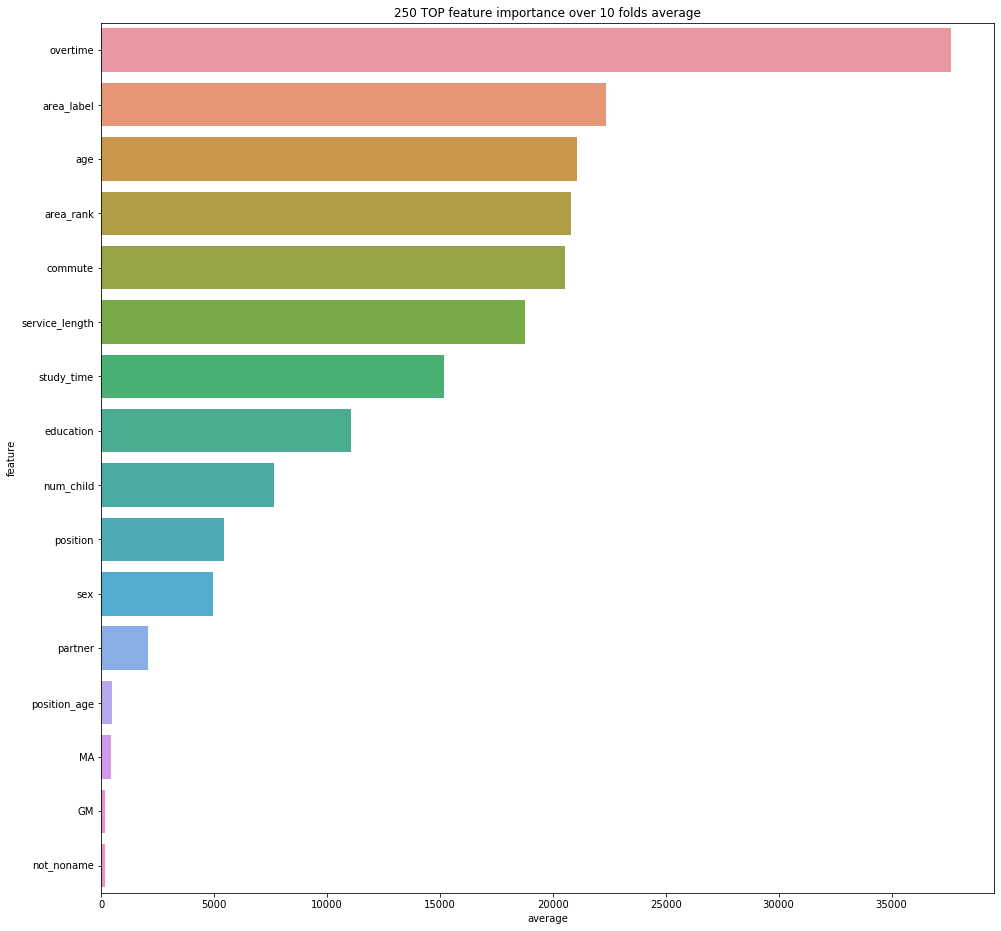

In [16]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(5)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('250 TOP feature importance over {} folds average'.format(10))
#plt.savefig('TOP250_feature_importance.png')
plt.show()

In [17]:
sub = pd.DataFrame({'id': test_id, 'y': pred})

In [18]:
sub.head()

,id,y
0,0,520
1,1,272
2,2,205
3,3,158
4,4,289


In [19]:
sub.to_csv('sub_lgb_noncat.csv', index=None)